# The Tractable Buffer Stock Model

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/tractablebufferstock-interactive#launch)


<p style="text-align: center;"><small><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></small></p>

The [TractableBufferStock](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock/) model is a (relatively) simple framework that captures all of the qualitative, and many of the quantitative features of optimal consumption in the presence of labor income uncertainty.  

In [1]:
# This cell has a bit of (uninteresting) initial setup.

import matplotlib.pyplot as plt

import numpy as np
import HARK 
from copy import deepcopy
mystr = lambda number : "{:.3f}".format(number)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from HARK.utilities import plotFuncs

In [2]:
# Import the model from the toolkit
from HARK.ConsumptionSaving.TractableBufferStockModel import TractableConsumerType

The key assumption behind the model's tractability is that there is only a single, stark form of uncertainty:  So long as an employed consumer remains employed, that consumer's labor income $P$ will rise at a constant rate $\Gamma$:
\begin{align}
P_{t+1} &= \Gamma P_{t}
\end{align}

But, between any period and the next, there is constant hazard $p$ that the consumer will transition to the "unemployed" state. Unemployment is irreversible, like retirement or disability.  When unemployed, the consumer receives a fixed amount of income (for simplicity, zero).  (See the [linked handout](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock/) for details of the model).

Defining $G$ as the growth rate of aggregate wages/productivity, we assume that idiosyncratic wages grow by $\Gamma = G/(1-\mho)$ where $(1-\mho)^{-1}$ is the growth rate of idiosyncratic productivity ('on-the-job learning', say).  (This assumption about the relation between idiosyncratic income growth and idiosyncratic risk means that an increase in $\mho$ is a mean-preserving spread in human wealth; again see [the lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock/)).

Under CRRA utility $u(C) = \frac{C^{1-\rho}}{1-\rho}$, the problem can be normalized by $P$.  Using lower case for normalized varibles (e.g., $c = C/P$), the normalized problem can be expressed by the Bellman equation:

\begin{eqnarray*}
v_t({m}_t) &=& \max_{{c}_t} ~ U({c}_t) + \beta \Gamma^{1-\rho} \overbrace{\mathbb{E}[v_{t+1}^{\bullet}]}^{=p v_{t+1}^{u}+(1-p)v_{t+1}^{e}} \\
& s.t. & \\
{m}_{t+1} &=& (m_{t}-c_{t})\mathcal{R}  + \mathbb{1}_{t+1},
\end{eqnarray*}
where $\mathcal{R} = R/\Gamma$, and $\mathbb{1}_{t+1} = 1$ if the consumer is employed (and zero if unemployed).

Under plausible parameter values the model has a target level of $\check{m} = M/P$ (market resources to permanent income) with an analytical solution that exhibits plausible relationships among all of the parameters.  

Defining $\gamma = \log \Gamma$ and $r = \log R$, the handout shows that an approximation of the target is given by the formula:

\begin{align}
\check{m} & = 1 + \left(\frac{1}{(\gamma-r)+(1+(\gamma/\mho)(1-(\gamma/\mho)(\rho-1)/2))}\right)
\end{align}


In [3]:
# Define a parameter dictionary and representation of the agents for the tractable buffer stock model
TBS_dictionary =  {'UnempPrb' : .00625,    # Prob of becoming unemployed; working life of 1/UnempProb = 160 qtrs
                   'DiscFac' : 0.975,      # Intertemporal discount factor
                   'Rfree' : 1.01,         # Risk-free interest factor on assets
                   'PermGroFac' : 1.0025,  # Permanent income growth factor (uncompensated)
                   'CRRA' : 2.5}           # Coefficient of relative risk aversion
MyTBStype = TractableConsumerType(**TBS_dictionary)

## Target Wealth

Whether the model exhibits a "target" or "stable" level of the wealth-to-permanent-income ratio for employed consumers depends on whether the 'Growth Impatience Condition' (the GIC) holds:

\begin{align}\label{eq:GIC}
 \left(\frac{(R \beta (1-\mho))^{1/\rho}}{\Gamma}\right)  & <  1
\\ \left(\frac{(R \beta (1-\mho))^{1/\rho}}{G (1-\mho)}\right)  &<  1
\\ \left(\frac{(R \beta)^{1/\rho}}{G} (1-\mho)^{-\rho}\right)  &<  1
\end{align}
and recall (from [PerfForesightCRRA](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA/)) that the perfect foresight 'Growth Impatience Factor' is 
\begin{align}\label{eq:PFGIC}
\left(\frac{(R \beta)^{1/\rho}}{G}\right)  &<  1
\end{align}
so since $\mho > 0$, uncertainty makes it harder to be 'impatient.'  To understand this, think of someone who, in the perfect foresight model, was 'poised': Exactly on the knife edge between patience and impatience.  Now add a precautionary saving motive; that person will now (to some degree) be pushed off the knife edge in the direction of 'patience.'  So, in the presence of uncertainty, the conditions on parameters other than $\mho$ must be stronger in order to guarantee 'impatience' in the sense of wanting to spend enough for your wealth to decline _despite_ the extra precautionary motive.

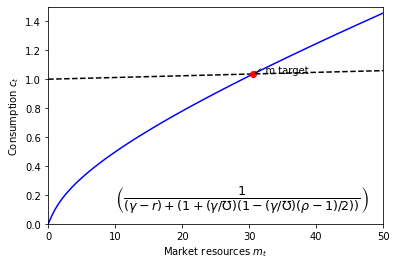

In [4]:
# Define a function that plots the employed consumption function and sustainable consumption function 
# for given parameter values

def makeTBSplot(DiscFac,CRRA,Rfree,PermGroFac,UnempPrb,mMax,mMin,cMin,cMax,plot_emp,plot_ret,plot_mSS,show_targ):
    MyTBStype.DiscFac = DiscFac
    MyTBStype.CRRA = CRRA
    MyTBStype.Rfree = Rfree
    MyTBStype.PermGroFac = PermGroFac
    MyTBStype.UnempPrb = UnempPrb
    
    try:
        MyTBStype.solve()
    except:
        print('Unable to solve; parameter values may be too close to their limiting values')    
    
    plt.xlabel('Market resources ${m}_t$')
    plt.ylabel('Consumption ${c}_t$')
    plt.ylim([cMin,cMax])
    plt.xlim([mMin,mMax])
    
    m = np.linspace(mMin,mMax,num=100,endpoint=True)
    if plot_emp:
        c = MyTBStype.solution[0].cFunc(m)
        c[m==0.] = 0.
        plt.plot(m,c,'-b')
        
    if plot_mSS:
        plt.plot([mMin,mMax],[(MyTBStype.PermGroFacCmp/MyTBStype.Rfree + mMin*(1.0-MyTBStype.PermGroFacCmp/MyTBStype.Rfree)),(MyTBStype.PermGroFacCmp/MyTBStype.Rfree + mMax*(1.0-MyTBStype.PermGroFacCmp/MyTBStype.Rfree))],'--k')
        
    if plot_ret:
        c = MyTBStype.solution[0].cFunc_U(m)
        plt.plot(m,c,'-g')
    
    if show_targ:
        mTarg = MyTBStype.mTarg
        cTarg = MyTBStype.cTarg
        targ_label = r'$\left(\frac{1}{(\gamma-r)+(1+(\gamma/\mho)(1-(\gamma/\mho)(\rho-1)/2))}\right) $' #+ mystr(mTarg) + '\n$\check{c}^* = $ ' + mystr(cTarg)
        plt.annotate(targ_label,xy=(0.0,0.0),xytext=(0.2,0.1),textcoords='axes fraction',fontsize=18)
        plt.plot(mTarg,cTarg,'ro')
        plt.annotate('↙️ m target',(mTarg,cTarg),xytext=(0.25,0.2),ha='left',textcoords='offset points')
    
    plt.show()
    return None

# Define widgets to control various aspects of the plot

# Define a slider for the discount factor
DiscFac_widget = widgets.FloatSlider(
    min=0.9,
    max=0.99,
    step=0.0002,
    value=TBS_dictionary['DiscFac'], # Default value
    continuous_update=False,
    readout_format='.4f',
    description='$\\beta$')

# Define a slider for relative risk aversion
CRRA_widget = widgets.FloatSlider(
    min=1.0,
    max=5.0,
    step=0.01,
    value=TBS_dictionary['CRRA'],  # Default value
    continuous_update=False,
    readout_format='.2f',
    description='$\\rho$')

# Define a slider for the interest factor
Rfree_widget = widgets.FloatSlider(
    min=1.01,
    max=1.04,
    step=0.0001,
    value=TBS_dictionary['Rfree'],  # Default value
    continuous_update=False,
    readout_format='.4f',
    description='$R$')


# Define a slider for permanent income growth
PermGroFac_widget = widgets.FloatSlider(
    min=1.00,
    max=1.015,
    step=0.0002,
    value=TBS_dictionary['PermGroFac'],  # Default value
    continuous_update=False,
    readout_format='.4f',
    description='$G$')

# Define a slider for unemployment (or retirement) probability
UnempPrb_widget = widgets.FloatSlider(
    min=0.000001,
    max=TBS_dictionary['UnempPrb']*2, # Go up to twice the default value
    step=0.00001,
    value=TBS_dictionary['UnempPrb'],
    continuous_update=False,
    readout_format='.5f',
    description='$\\mho$')

# Define a text box for the lower bound of {m}_t
mMin_widget = widgets.FloatText(
    value=0.0,
    step=0.1,
    description='$m$ min',
    disabled=False)

# Define a text box for the upper bound of {m}_t
mMax_widget = widgets.FloatText(
    value=50.0,
    step=0.1,
    description='$m$ max',
    disabled=False)

# Define a text box for the lower bound of {c}_t
cMin_widget = widgets.FloatText(
    value=0.0,
    step=0.1,
    description='$c$ min',
    disabled=False)

# Define a text box for the upper bound of {c}_t
cMax_widget = widgets.FloatText(
    value=1.5,
    step=0.1,
    description='$c$ max',
    disabled=False)

# Define a check box for whether to plot the employed consumption function
plot_emp_widget = widgets.Checkbox(
    value=True,
    description='Plot employed $c$ function',
    disabled=False)

# Define a check box for whether to plot the retired consumption function
plot_ret_widget = widgets.Checkbox(
    value=False,
    description='Plot retired $c$ function',
    disabled=False)

# Define a check box for whether to plot the sustainable consumption line
plot_mSS_widget = widgets.Checkbox(
    value=True,
    description='Plot sustainable $c$ line',
    disabled=False)

# Define a check box for whether to show the target annotation
show_targ_widget = widgets.Checkbox(
    value=True,
    description = 'Show target $(m,c)$',
    disabled = False)

# Make an interactive plot of the tractable buffer stock solution

# To make some of the widgets not appear, replace X_widget with fixed(desired_fixed_value) in the arguments below.
interact(makeTBSplot,
         DiscFac = DiscFac_widget,
         CRRA = CRRA_widget,
         # We can fix a parameter using the fixed() operator
         Rfree      = fixed(TBS_dictionary['Rfree']),
#         Rfree = Rfree_widget,   # This is the line which, when uncommented, would make Rfree a slider
         PermGroFac = PermGroFac_widget,
         UnempPrb = UnempPrb_widget,
         mMin = mMin_widget,
         mMax = mMax_widget,
         cMin = cMin_widget,
         cMax = cMax_widget,
         show_targ = show_targ_widget,
         plot_emp = plot_emp_widget,
         plot_ret = plot_ret_widget,
         plot_mSS = plot_mSS_widget,
        );